# Fold arbitrary fluxes through MagEIS isotropic response functions and compare with the official fluxes

This notebook explores how the flux calculated using the Bayes method compares to the publically avaliable values.

The steps are almost the same as the 2018-06-29_iso_R_arbitrary_spectra notebook, but uses the true MagEIS low count rates.

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Create a true exponential spectra with E0t and J0t parameters. 
Then use that spectra and fold it through the MagEIS response functions to get true counts as a function of energy channel.

In [2]:
# Initialize the response function
# RBSP-A MagEIS LOW LUT=16386 from 2016-01-01 (same for all day)
R = mageis_response.R_iso(101, lut=16386, magB=1065)
print('Using MagEIS calibration file: {}'.format(R._cal_file))
E = 1000*R.E # energy (keV).
n_ch = (1, 9) # Use the main rate channels and ignore the first channel (is it junk?)

Using MagEIS calibration file: /home/msshumko/Documents/mageis-stats/utils/mageis_response_files/low/rbsp_mageis_low_101_1065_MR_16386.mat


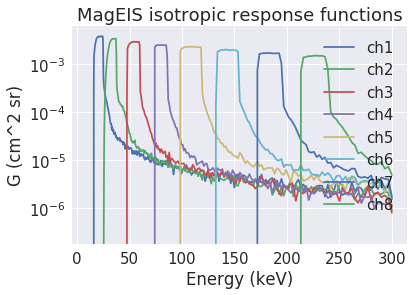

In [3]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS isotropic response functions'); plt.yscale('log');
plt.legend(); #plt.savefig('response.png', dpi=300)

The observed count rates and the official flux from 2016-01-01T00:00:02.823000

In [24]:
c_obs = np.array([33758.242, 30543.17, 17682.889, 12860.282,
       10047.096, 2411.303, 1105.1805, 552.5903]) # Counts/s
FEDU = [1.2161670e+06, 1.1864615e+06, 5.3590431e+05,
        4.5189862e+05, 2.2285083e+05, 5.6950922e+04, 2.7401449e+04,
        1.4226637e+04] # Flux from Channels 1-9 (cm^2 s sr keV)^-1
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.] # keV

### Model the energy channel-dependent flux 

In [5]:
# Define the energy channel boundaries for the spectra
nE = 5
E_bins = np.linspace(E[0], E[-1], num=nE+1)
istart = [np.where(E >= i)[0][0] for i in E_bins][:-1]
iend = [np.where(E <= i)[0][-1] for i in E_bins][1:]

In [6]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    """
    lams = (n_ch[1]-n_ch[0])*[0] 
    
    for ch in range(*n_ch):
        # Reset count counter.
        ch_c = 0 
        for i in range(nE):
            # Fold the flux through R
            f = pm.math.dot(JJ[i], R.response(ch)[istart[i]:iend[i]])
            # Calc count contribution to chth energy channel by the ith flux.
            ch_c += pymcTrapz(f, E[istart[i]:iend[i]]) 
        # Save the total counts in chth energy channel from 
        # contributions from all of the fluxes.
        lams[ch-n_ch[0]] = pm.Deterministic('lam{}'.format(ch), ch_c)
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    J = pm.Uniform('J', lower=0, upper=1E7, shape=nE)
    
    lams = lam(J) # Get the count values from the picked J array of values.
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [J_interval__]
  2%|▏         | 219/10500.0 [00:11<08:53, 19.28it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '22766' (I am process '22767')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/msshumko/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-redhat-7.5-Maipo-x86_64-3.6.0-64/lock_dir
100%|██████████| 10500/10500.0 [03:24<00:00, 51.29it/s]
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


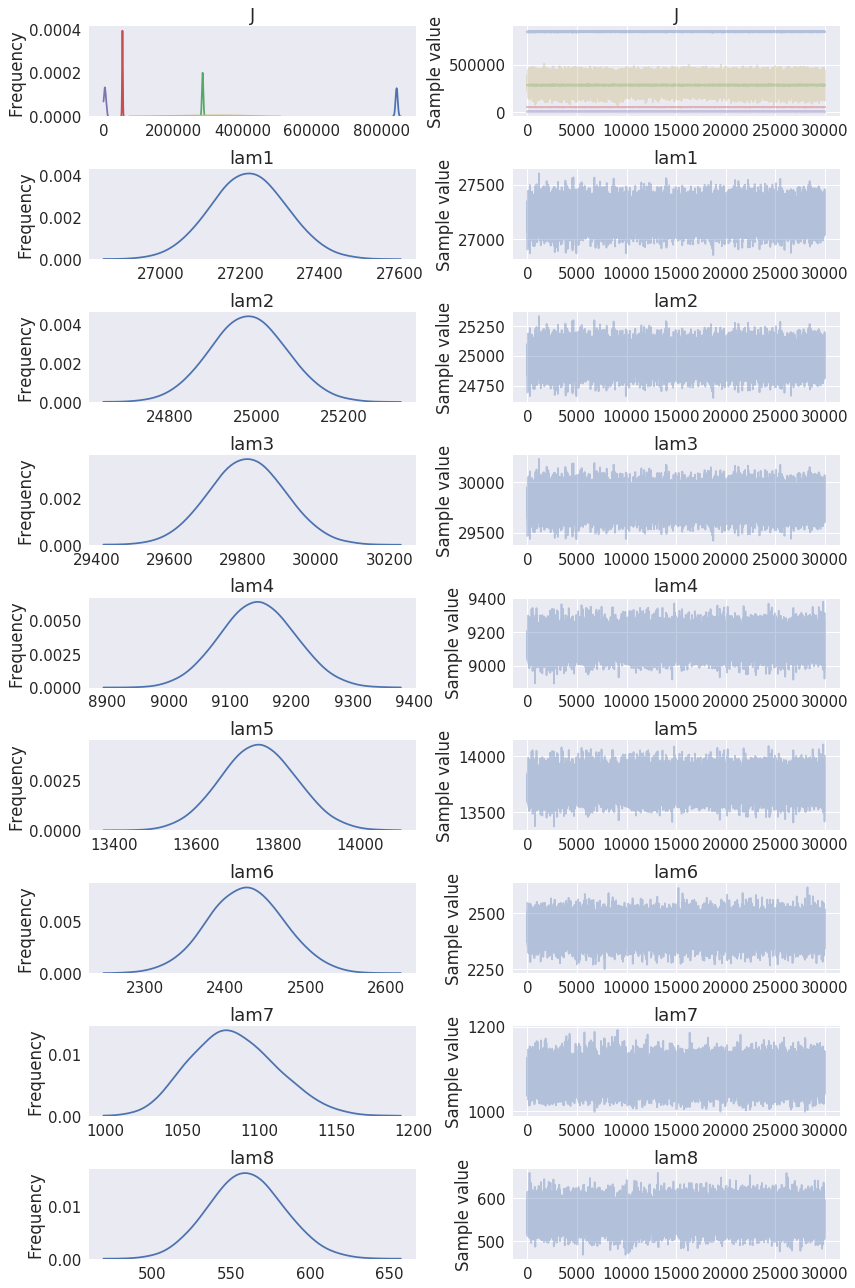

In [7]:
pm.traceplot(trace, combined=True);

In [8]:
pm.summary(trace)

mean            sd     mc_error        hpd_2.5       hpd_97.5  \
J__0  843558.723805   2967.805299    21.911969  837726.347035  849311.987282   
J__1  285339.064052   1920.178192    16.197631  281530.625094  289013.415788   
J__2   54683.204672   1002.713528     7.698710   52734.954713   56689.526979   
J__3    4818.466717   2734.601650    36.528986      13.259553    9749.637811   
J__4  303599.274178  83262.587249  1117.182434  143845.009348  452612.061052   
lam1   27218.899211     94.751620     0.688662   27034.420630   27405.371710   
lam2   24978.270100     86.901281     0.631705   24809.908851   25150.106157   
lam3   29809.659326    103.572343     0.754284   29607.460346   30012.498692   
lam4    9144.121373     60.717298     0.493641    9025.849199    9263.658020   
lam5   13750.856150     91.056610     0.737243   13567.878872   13924.369617   
lam6    2424.860659     46.671034     0.379079    2334.189332    2517.558913   
lam7    1083.197736     27.785225     0.333731    1031.074927    1137.676099   
lam8     559.480231     23.637383     0.156870     513.485580     605.766539   

             n_eff      Rhat  
J__0  17742.853228  0.999970  
J__1  14363.057265  0.999992  
J__2  16176.023415  0.999980  
J__3   5550.230998  1.000021  
J__4   5395.744798  1.000036  
lam1  18000.791874  0.999980  
lam2  18004.138949  0.999979  
lam3  17987.649635  0.999976  
lam4  15239.399836  0.999994  
lam5  15325.362997  0.999994  
lam6  15236.858255  0.999990  
lam7   6620.292442  0.999994  
lam8  24718.755453  0.999975

In [13]:
#for ch in range(nE):
#    plt.hist(trace['J'][:, ch], alpha=0.7, bins=100, label='ch{}'.format(ch))
#plt.legend(); plt.title('Flux traces'); plt.ylabel('#'); plt.xlabel('Flux');

Now use the traces to calculate the modeled counts and uncertainties, as well as the flux means and stds.

In [18]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(*n_ch)]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(*n_ch)]
c_ci = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(*n_ch)])

j_mean = np.mean(trace['J'], axis=0)
j_std = np.std(trace['J'], axis=0)
j_ci = np.percentile(trace['J'], (2.5, 97.5), axis=0) 

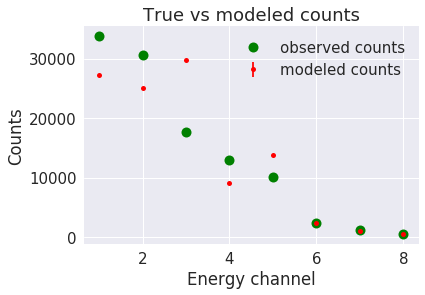

In [20]:
plt.plot(np.arange(*n_ch), c_obs, 'go', label='observed counts', ms=10);
plt.errorbar(np.arange(*n_ch), c_mean, fmt='ro', yerr=c_mean-c_ci.T, label='modeled counts', ms=5);
plt.legend(); plt.title('True vs modeled counts'); plt.xlabel('Energy channel');
plt.ylabel('Counts');

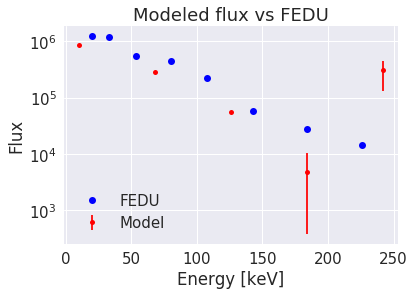

In [17]:
plt.errorbar(E_bins[:-1], j_mean, 
             fmt='ro', yerr=np.abs(j_ci-j_mean), label='Model', ms=5);
#plt.plot(np.arange(*n_ch), official_flux, 'bo', label='Official')
plt.plot(FEDU_energy[1:], np.array(FEDU), 'bo', label='FEDU')
plt.title('Modeled flux vs FEDU'); plt.xlabel('Energy [keV]'); plt.ylabel('Flux');
plt.yscale('log'); plt.legend(); #plt.savefig('flux_compare.png', dpi=300)